### Решающие деревья (decision trees)
Решающие деревья - это такое семейство моделей, которое позволяет предсказывать значение целевой переменной с помощью применения последовательности простых решающих правил (которые называются предикатами). Этот процесс в некотором смысле согласуется с естественным для человека процессом принятия решений. Хотя обобщающая способность решающих деревьев невысока, их предсказания вычисляются довольно просто, из-за чего решающие деревья часто используют как составные элементы для построения **ансамблей** — моделей, делающих предсказания на основе агрегации предсказаний других моделей. Рассмотрим простой пример дерева:

<center><img src="data//tree_example.png" alt="drawing" width="800"/></center>

Объекты в этом примере имеют два признака с вещественными значениями: $X$ и $Y$. Решение о том, к какому классу будет отнесён текущий объект выборки, будет приниматься с помощью прохода от **корня** дерева к некоторому **листу**.

В каждом **узле** этого дерева находится предикат. Если предикат верен для текущего примера из выборки, мы переходим в правого потомка, если нет — в левого. В **листьях** записаны предсказания (например, метки классов). Как только мы дошли до листа, мы присваиваем объекту ответ, записанный в вершине.

Рассмотрим двумерные данные, какждый элемент которых принадлежит одному из 4 классов.

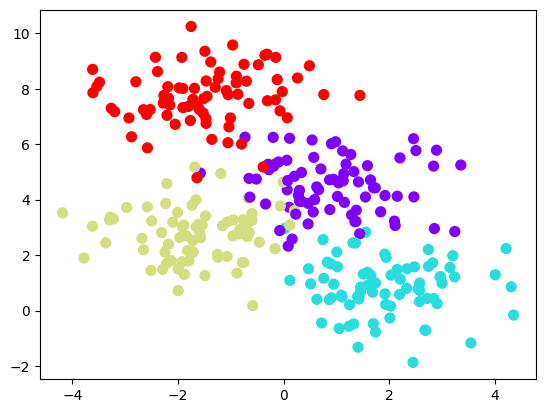

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Решающее дерево будет разделять данные вдоль одной из осей в соответствии с некоторым критерием и присваивать области класс/лейбл в соответствии с количеством объектов в ней (по принципу головования).

<center><img src="data//trees_depths.png" alt="drawing" width="1400"/></center>

Как и в первом примере разбиение происходит на основе значения какого-то признака. Мы сравниваем его с некоторым порогом и решаем, в какую ветвь дерева перейдет этот объект. В предыдущих примерах мы имели дело с простыми, синтетическими данными, но в реальных задачах признаков довольно много. Например, в задаче кредитного скоринга у нас есть информация о возрасте клиента, его зарплате, наличии/отсутствии недвижимости и т.д. Встает вопрос: какой признак выбрать первым? Интуитивно понятно, что признак "месячный доход" в данном случае будет гораздо **информативней** чем, например, "слушает классическую музыку". Понятие информативности довольно важное при рассмотрении решающих деревьев, чем она ниже, тем лучше объекты в листе можно приблизить константным значением. Рассмотрим информативность в задаче классификации, для этого необходимо ввести понятие **энтропии**

### Энтропия
В теории информации энропия представляет собой меру неопределенности некоторой системы. Если имеется $N$ возможных состояний, то энтропию можно записать следующим образом:
$$S=-\sum\limits_{i=1}^N p_i log_2(p_i)$$
где $p_i$ – вероятности нахождения системы в $i$-ом состоянии.

Рассмотрим случай, когда имеется 2 возможных исхода события (0 и 1). Тогда энтропия примет вид $S=-p log_2(p)-(1-p)log(1-p)$

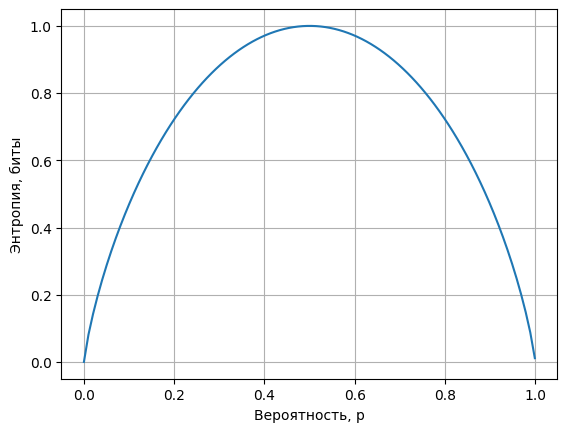

In [2]:
p = np.linspace(1e-5, 0.999, 100)
S = -p*np.log2(p)-(1-p)*np.log2(1-p)
plt.plot(p, S)
plt.xlabel('Вероятность, p')
plt.ylabel('Энтропия, биты')
plt.grid()

Если логарифм в уравнении берется по основанию 2, единица измерения $S$ (часто энтропию еще обозначают буквой $Н$) — среднее число бит на событие. Здесь единица измерения бит — это мера 
количества информации, и ее не следует путать с термином "бит", означающим "двоичная цифра" (binary digit — bit). Для информационного источника с двумя равновероятными состояниями (например, выбрасывание монеты правильной формы) видно, что неопределенность исхода и, следовательно, среднее количество информации максимальны. 

Как только вероятности уходят от равновероятного состояния, среднее количество информации снижается. В пределе, когда одна из вероятностей обращается в нуль, энтропия также обращается в нуль. Результат известен до того, как произойдет событие, так что исход не несет в себе дополнительной информации.

Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения, рассмотрим пример, в котором будем предсказывать цвет шарика по его координате. 

<center><img src="data//balls_example.png" alt="drawing" width="700"/></center>

изначально имеем 9 синих шариков и 11 оранжевых. Вероятность достать синий равна $p_1=\frac{9}{20}$, а оранжевый $p_2=\frac{11}{20}$. Энропия в таком, "начальном" состоянии равна $S_0 = -\frac{9}{20}log_2\frac{9}{20}-\frac{11}{20}log_2\frac{11}{20} =0.9928 \approx1$. Если мы возьмем признак $X$ и разобъем шарики на две группы - с координатой меньше либо равной 12 и больше 12 - то в левой группе окажется 13 шаров, из которых 8 синих и 5 желтых. Энтропия будет равна $S_1 = -\frac{5}{13}log_2\frac{5}{13}-\frac{8}{13}log_2\frac{8}{13} \approx 0.96$. В правой же группе окажется 7 шаров, из которых 1 синий и 6 желтых, а энтропия $S_2 = -\frac{1}{7}log_2\frac{1}{7}-\frac{6}{7}log_2\frac{6}{7} \approx 0.6$. Энтропия уменьшилась в обеих группах (хоть в первой и не сильно). Уменньшение энтропии еще называют **приростом информации** (information gain, IG). Он определяется следующим образом:

$$IG(Q)= S_0-\sum\limits_{i=1}^q\frac{N_i}{N}S_i,$$
где $q$ - число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение. Найдем прирост информации для рассмотренного примера: $q = 2$ (2 группы после разбиения), в первой группе 13 элементов ($N_1 = 13$), во второй - 7 ($N_2 = 7$), тогда 
$$IG(x\leq12)= S_0-\frac{13}{20}S_1-\frac{7}{20}S_2\approx0.16$$

Можем продолжить делить группы шариков, чтобы добиться идеальной классификации. Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($\log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку.

Помимо энтропии существуют и другие критерии качества разбиения:
- Неопределенность Джини (Gini impurity): 
$$G = 1 - \sum\limits_k (p_k)^2$$
Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Не путать с индексом Джини.
- Ошибка классификации (misclassification error): 
$$E = 1 - \max\limits_k p_k$$

C:\Users\user\AppData\Local\Temp\ipykernel_14212\940973643.py:5: RuntimeWarning: divide by zero encountered in log2
  plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
C:\Users\user\AppData\Local\Temp\ipykernel_14212\940973643.py:5: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')


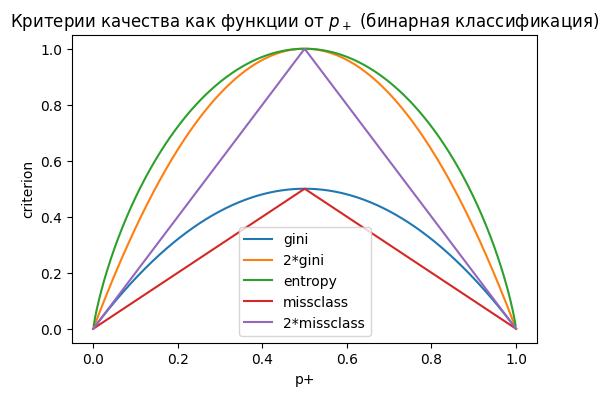

In [3]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,1000)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от $p_+$ (бинарная классификация)')
plt.legend();

### Построение дерева

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип **жадной максимизации** прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).

В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева. Предположим мы построили дерево и оно получилось глубокое, то есть почти наверное переобученное. В такой ситуации используют **pruning** - cтрижка дерева. При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него. Также с переобучением борются путем ограничения **глубины** или **минимального числа объектов** в листе: построение дерева просто в какой-то момент прекращается.

*Плюсы алгоритма*:
- Интерпретируемость
- Возможность решать и регрессионные задачи, и классификационные
- Возможность обрабатывать разнотипные данные, а также пропуски
  
*Минусы*:
- Жадный алгоритм построение переусложняет структуру дерева, как следствие оно сильно переобучается.
- Чувствительность к шуму, к составу выборку, к критерию информативности
  
Как упоминалось ранее, решающие деревья являются кирпичиком при построении ансамблей. Например, в алгоритме случайного леса (Random Forest) используются намеренно переобученные (глубокие) деревья, а в градиентном бустинге (Gradient Boosting) мы как правило строим неглубокие деревья.

### Decision Trees в Scikit-learn

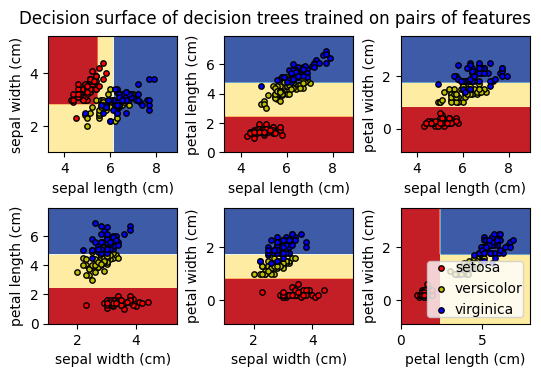

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

def plot_decision_bnd(X, y, n_classes=3, plot_colors="ryb"):
    # Изобразим разделяющую плоскость
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=iris.feature_names[pair[0]],
        ylabel=iris.feature_names[pair[1]],
    )

    # Изобразим данные
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            edgecolor="black",
            s=15,
        )

# Будем брать пары признаков и обучаться на них
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier(max_depth=2).fit(X, y)
    # Визуализация
    plot_decision_bnd(X, y)

    

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")

Text(0.5, 1.0, 'Decision tree graph')

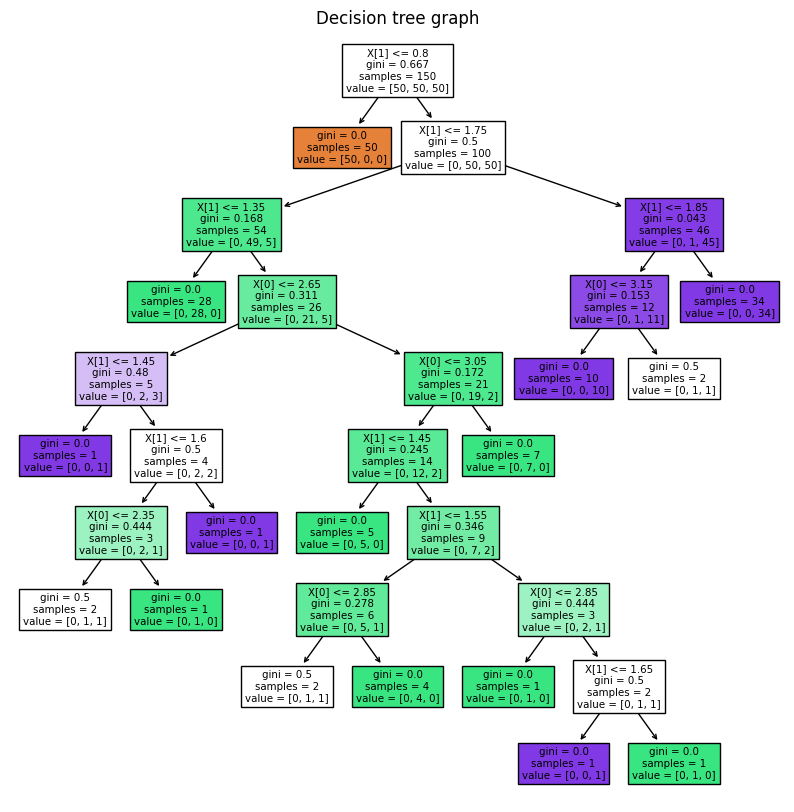

In [5]:
from sklearn.tree import plot_tree

X = iris.data[:, [1, 3]]
y = iris.target
plt.figure(figsize=(10,10))
clf = DecisionTreeClassifier().fit(X, y)
plot_tree(clf, filled=True)
plt.title("Decision tree graph")


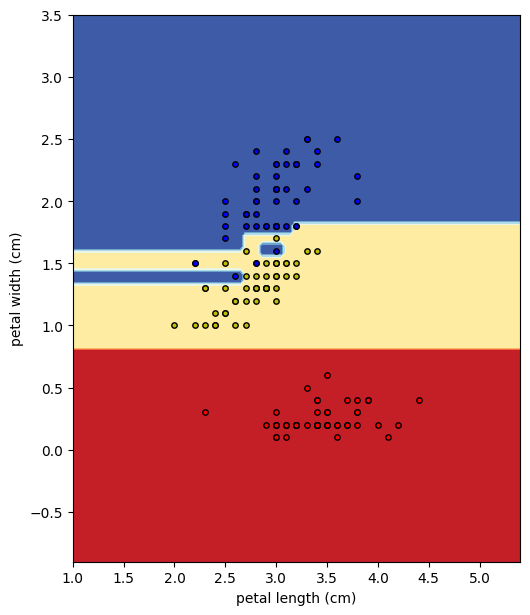

In [6]:
plt.figure(figsize=(15,12))
plot_decision_bnd(X, y)